In [ ]:
import os
import random

import cv2
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint 
from tqdm import tqdm
from sklearn.metrics import classification_report

In [5]:

def show_video(path: str):

    # Cargar el video
    cap = cv2.VideoCapture(path)

    # Verificar si el video se cargó correctamente
    if not cap.isOpened():
        print("Error al cargar el video.")
        cap.release()
        exit()

    # Leer y mostrar cuadro por cuadro
    while True:
        ret, frame = cap.read()  # Leer un cuadro
        if not ret:  # Si no hay más cuadros, salir del bucle
            print("Fin del video.")
            break

        # Convertir el cuadro a RGB (OpenCV usa BGR por defecto)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Mostrar el cuadro en el notebook
        plt.imshow(frame_rgb)
        plt.axis('off')  # Ocultar ejes
        clear_output(wait=True)  # Limpiar la salida anterior
        plt.show()

        # Detener la reproducción después de cierto tiempo
        cv2.waitKey(1)  # Ajusta la velocidad de reproducción

    cap.release()

non violence

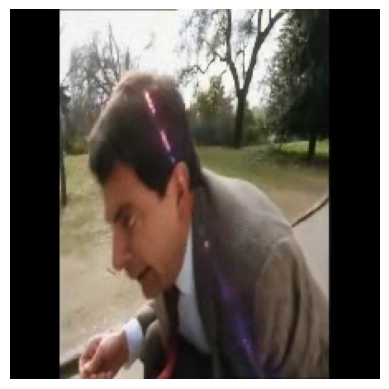

Fin del video.


In [7]:
show_video("data/archive(4)/Real Life Violence Dataset/NonViolence/NV_412.mp4")

violence

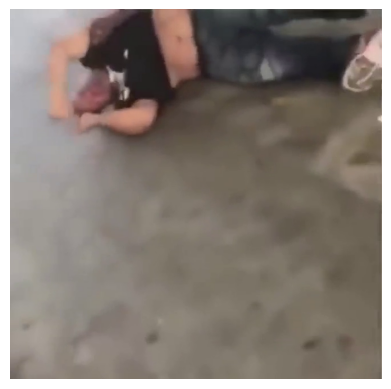

Fin del video.


In [6]:
show_video("data/archive(4)/Real Life Violence Dataset/Violence/V_29.mp4")

In [11]:
# Function to extract frames at a rate of 3 frames per second
def extract_frames(video_path, output_folder, target_fps=3):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return
    
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    frame_interval = int(original_fps / target_fps)
    frame_count, saved_frame_count = 0, 0
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_filename = f"{os.path.splitext(os.path.basename(video_path))[0]}_frame{saved_frame_count}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_filename), frame)
            saved_frame_count += 1
        frame_count += 1
    cap.release()

In [ ]:
# Function to process videos, splitting 10% for validation if needed
def process_videos(video_paths, train_output, val_output, split_for_val=True):
    for folder in video_paths:
        video_files = [f for f in os.listdir(folder) if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))]
        
        if split_for_val:
            random.shuffle(video_files)
            val_count = int(len(video_files) * 0.1)  # Take 10% for validation
            val_videos, train_videos = video_files[:val_count], video_files[val_count:]
        else:
            val_videos, train_videos = [], video_files  # All to training if no split
        
        # Extract frames from validation videos
        for video_file in tqdm(val_videos, desc=f"Extracting validation frames from {folder}"):
            extract_frames(os.path.join(folder, video_file), val_output)

        # Extract frames from training videos
        for video_file in tqdm(train_videos, desc=f"Extracting training frames from {folder}"):
            extract_frames(os.path.join(folder, video_file), train_output)

In [20]:
root_data_extracted_path = "data/extracted_frames/"

train_path = f"{root_data_extracted_path}/train"
test_path = f"{root_data_extracted_path}/test"

In [21]:
# Process violence and nonviolence folders with a 10% split for validation
# process_videos(
#     ["data/Violence"],
#     f"{train_path}/violence",
#     f"{test_path}/violence"
# )

process_videos(
    ["data/nonviolence"],
    f"{train_path}/nonviolence",
    f"{test_path}/nonviolence"
)


print("Frame extraction completed.")

Extracting validation frames from data/nonviolence:   0%|          | 0/100 [00:00<?, ?it/s]

Extracting validation frames from data/nonviolence:  72%|███████▏  | 72/100 [02:16<00:56,  2.00s/it][h264 @ 0x656ce80] mb_type 104 in P slice too large at 98 31
[h264 @ 0x656ce80] error while decoding MB 98 31
Extracting validation frames from data/nonviolence: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]
Extracting training frames from data/nonviolence: 100%|██████████| 900/900 [37:26<00:00,  2.50s/it] 

Frame extraction completed.


In [22]:
# Dictionary to store file counts
file_counts = {}

# Walk through each subdirectory and count files
for root, dirs, files in os.walk(root_data_extracted_path):
    # Only count files, skip directories
    file_counts[root] = len(files)

# Print the file counts in each folder
for folder, count in file_counts.items():
    print(f"{folder}: {count} files")

data/extracted_frames/: 0 files
data/extracted_frames/train: 0 files
data/extracted_frames/train/violence: 15763 files
data/extracted_frames/train/violence/non_violence: 0 files
data/extracted_frames/train/nonviolence: 15166 files
data/extracted_frames/test: 0 files
data/extracted_frames/test/violence: 1564 files
data/extracted_frames/test/nonviolence: 1620 files


In [ ]:
# input_dir = "data/extracted_frames/train/nonviolence"
# output_dir = "data/extracted_frames/train/nonviolence_rezised"

# os.makedirs(output_dir, exist_ok=True)

# new_size = (640, 640)  # Nuevo tamaño

# for filename in os.listdir(input_dir):
#     if filename.endswith(".jpg"):
#         img_path = os.path.join(input_dir, filename)
#         img = cv2.imread(img_path)
#         img_resized = cv2.resize(img, new_size)
#         cv2.imwrite(os.path.join(output_dir, filename), img_resized)

KeyboardInterrupt: 

In [56]:
img_size = (32, 32)


train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=640,
    label_mode="binary",
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=640,
    label_mode="binary",
)

Found 30929 files belonging to 2 classes.
Found 3184 files belonging to 2 classes.


In [57]:
train_dataset.classes

AttributeError: '_PrefetchDataset' object has no attribute 'classes'

In [45]:
true_classes = test_dataset.class_names

In [47]:
#Normalize images

def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

train_dataset = train_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

In [40]:

# Define the MobileNetV3Small model
input_tensor = Input(shape=(img_size[0], img_size[1], 3))
base_model = MobileNetV3Small(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')



base_model.trainable = True  # Initially freeze the entire base model
"""# Unfreeze the top 10 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True
    , kernel_regularizer=l2(0.01)
"""
    

# Add custom layers on top of MobileNetV3Small
x = base_model(input_tensor)
x = GlobalAveragePooling2D()(x)

x = Dense(64)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)  # Add Dropout

x = Dense(32)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)  # Add Dropout

output = Dense(1, activation='sigmoid')(x)

# Build the model
model = models.Model(inputs=input_tensor, outputs=output)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 1, 1, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_38 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_39 (Activation)      │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 978,161 (3.73 MB)

 Trainable params: 966,049 (3.69 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [41]:
model.compile(optimizer=Adam(learning_rate=1e-4),  # Lower LR for fine-tuning
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks for adaptive learning rate and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)  
#early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',  # Path to save the best model
    monitor='val_loss',       # Metric to monitor for improvement
    save_best_only=True,      # Save only if the model improves
    mode='min',               # Mode: 'min' for loss, 'max' for accuracy
    verbose=1                 # Print messages when saving
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=30,
    callbacks=[checkpoint,reduce_lr]
)

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.5046 - loss: 1.1309
Epoch 1: val_loss improved from inf to 0.73452, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 85s 617ms/step - accuracy: 0.5047 - loss: 1.1291 - val_accuracy: 0.5088 - val_loss: 0.7345 - learning_rate: 1.0000e-04
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.5177 - loss: 0.8590
Epoch 2: val_loss improved from 0.73452 to 0.69380, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 711ms/step - accuracy: 0.5177 - loss: 0.8586 - val_accuracy: 0.5088 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.5243 - loss: 0.7780
Epoch 3: val_loss did not improve from 0.69380
49/49 ━━━━━━━━━━━━━━━━━━━━ 30s 595ms/step - accuracy: 0.5243 - loss: 0.7777 - val_accuracy: 0.5088 - val_loss: 0.6947 - learning_rate: 1.0000e-04
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.5293 - loss: 0.7373
Epoch

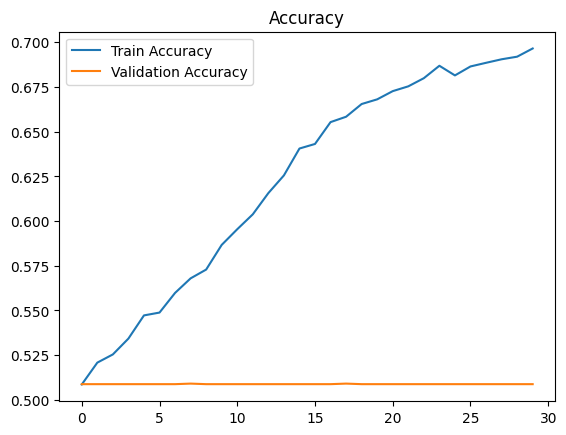

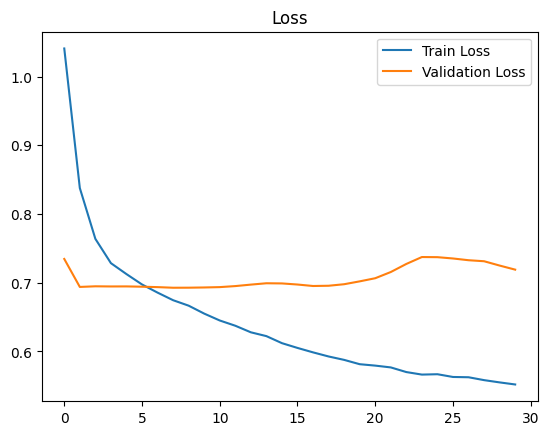

In [51]:
# Plotear precisión
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()

# Plotear pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

In [67]:
# Step 1: Evaluate the model using the validation generator
loss, accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - accuracy: 0.5063 - loss: 33.8777
Validation Loss: 36.141117095947266
Validation Accuracy: 0.5037688612937927


In [59]:
import numpy as np

# Obtener etiquetas verdaderas
y_true = []
y_pred = []

for images, labels in test_dataset:
    # Etiquetas reales
    y_true.extend(labels.numpy())
    # Predicciones del modelo
    preds = model.predict(images)  # Si es clasificación binaria
    y_pred.extend(np.round(preds).flatten())  # Redondear para obtener 0 o 1

y_true = np.array(y_true)
y_pred = np.array(y_pred)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


2024-12-01 11:08:19.069301: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
from sklearn.metrics import classification_report

# Generar el informe
report = classification_report(y_true, y_pred, target_names=test_dataset.class_names)
print(report)

              precision    recall  f1-score   support

 nonviolence       0.52      0.41      0.46      1620
    violence       0.50      0.60      0.54      1564

    accuracy                           0.50      3184
   macro avg       0.51      0.51      0.50      3184
weighted avg       0.51      0.50      0.50      3184

